In [ ]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn wordcloud nltk

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from collections import Counter
import re

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

print("Libraries imported successfully!")

Libraries imported successfully!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load the dataset
# Since you've provided the file content, I'll create a DataFrame from it
import io

# Create DataFrame from the provided CSV content
df = pd.read_csv('spam.csv', encoding='latin-1')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (5572, 5)

First 5 rows:


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Step 2: Data Cleaning and Preprocessing

In [ ]:
# Let's inspect the dataset structure
print("Dataset Info:")
print(df.info())
print("\nColumn names:")
print(df.columns.tolist())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None

Column names:
['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

Missing values:
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [ ]:
# Clean the dataset - keep only relevant columns
# The dataset has extra columns with mostly NaN values
df_clean = df[['v1', 'v2']].copy()

# Rename columns for better understanding
df_clean.columns = ['label', 'message']

print("Cleaned dataset shape:", df_clean.shape)
print("\nFirst 5 rows of cleaned data:")
df_clean.head()

Cleaned dataset shape: (5572, 2)

First 5 rows of cleaned data:


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Check for any missing values
print("Missing values in cleaned dataset:")
print(df_clean.isnull().sum())

# Check the distribution of labels
print("\nLabel distribution:")
print(df_clean['label'].value_counts())
print("\nLabel percentages:")
print(df_clean['label'].value_counts(normalize=True) * 100)

Missing values in cleaned dataset:
label      0
message    0
dtype: int64

Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Label percentages:
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


### Step 3: Exploratory Data Analysis

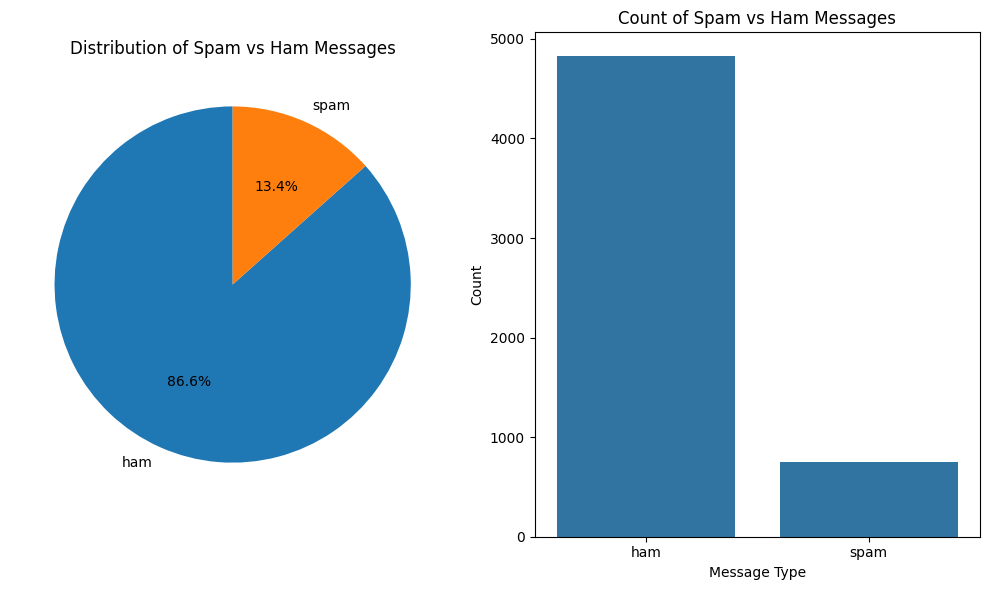

In [ ]:
# Visualize the distribution of spam vs ham
plt.figure(figsize=(10, 6))

# Pie chart
plt.subplot(1, 2, 1)
label_counts = df_clean['label'].value_counts()
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Spam vs Ham Messages')

# Bar plot
plt.subplot(1, 2, 2)
sns.countplot(data=df_clean, x='label')
plt.title('Count of Spam vs Ham Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# Analyze message length characteristics
df_clean['message_length'] = df_clean['message'].apply(len)
df_clean['word_count'] = df_clean['message'].apply(lambda x: len(x.split()))

print("Message Length Statistics:")
print(df_clean.groupby('label')['message_length'].describe())

Message Length Statistics:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


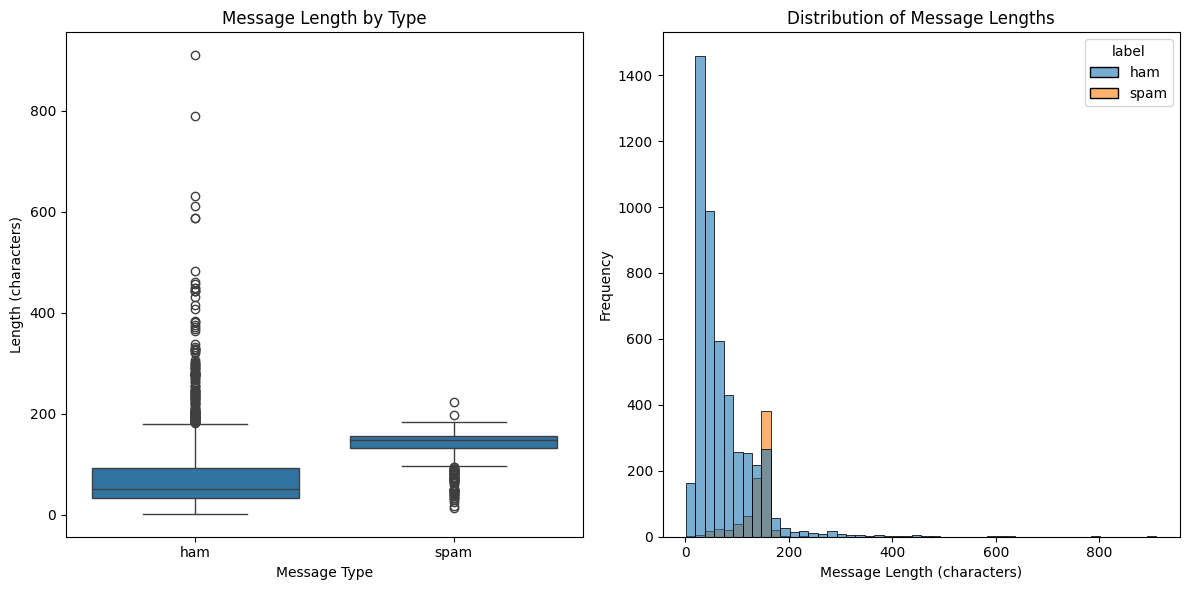

In [ ]:
# Visualize message length distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_clean, x='label', y='message_length')
plt.title('Message Length by Type')
plt.xlabel('Message Type')
plt.ylabel('Length (characters)')

plt.subplot(1, 2, 2)
sns.histplot(data=df_clean, x='message_length', hue='label', bins=50, alpha=0.6)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Step 4: Text Analysis - Word Frequency


In [ ]:
# Function to clean and tokenize text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Separate spam and ham messages
spam_messages = df_clean[df_clean['label'] == 'spam']['message']
ham_messages = df_clean[df_clean['label'] == 'ham']['message']

print(f"Number of spam messages: {len(spam_messages)}")
print(f"Number of ham messages: {len(ham_messages)}")

Number of spam messages: 747
Number of ham messages: 4825


In [ ]:
nltk.download('punkt_tab')
# Get most common words in spam messages
spam_words = []
for message in spam_messages:
    spam_words.extend(clean_text(message))

spam_word_freq = Counter(spam_words)
print("Top 20 words in SPAM messages:")
for word, count in spam_word_freq.most_common(20):
    print(f"{word}: {count}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Top 20 words in SPAM messages:
call: 349
free: 219
txt: 150
mobile: 124
text: 121
stop: 116
claim: 113
reply: 101
prize: 92
get: 83
nokia: 69
new: 69
send: 67
urgent: 63
cash: 62
win: 61
contact: 56
service: 55
please: 54
guaranteed: 50


In [ ]:
# Get most common words in ham messages
ham_words = []
for message in ham_messages:
    ham_words.extend(clean_text(message))

ham_word_freq = Counter(ham_words)
print("Top 20 words in HAM messages:")
for word, count in ham_word_freq.most_common(20):
    print(f"{word}: {count}")

Top 20 words in HAM messages:
get: 307
ltgt: 276
dont: 257
got: 244
ill: 236
know: 232
like: 229
call: 229
come: 224
good: 222
day: 191
time: 189
love: 185
going: 167
want: 163
one: 162
home: 160
lor: 160
need: 156
sorry: 153


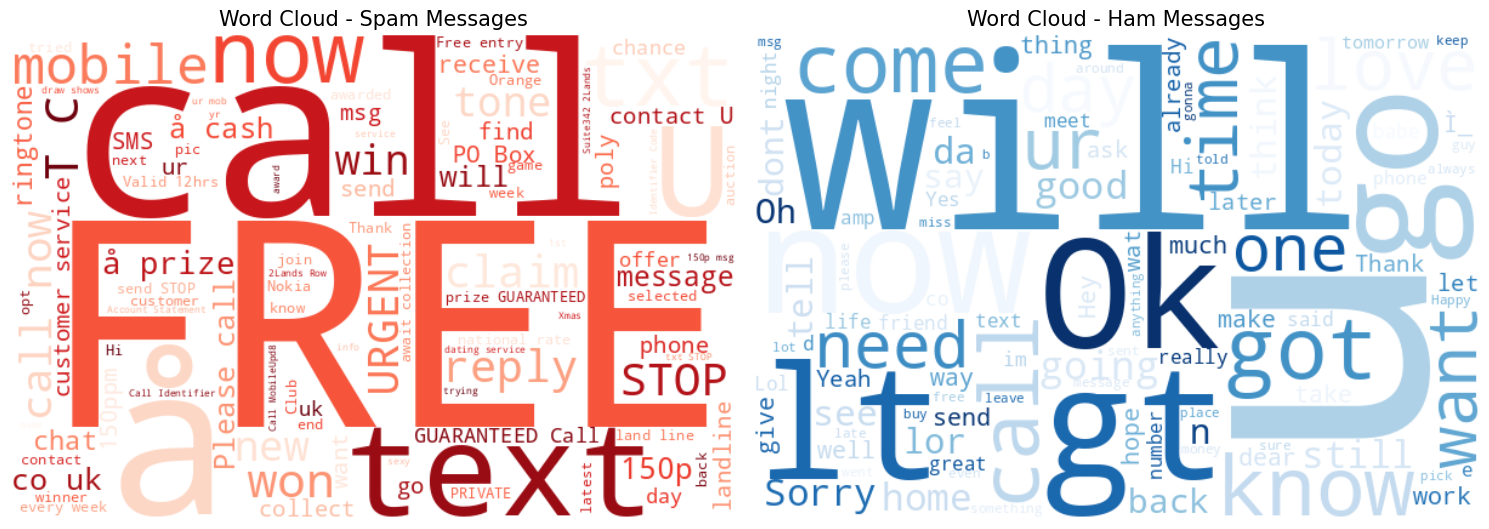

In [ ]:
# Generate word clouds
plt.figure(figsize=(15, 8))

# Spam word cloud
plt.subplot(1, 2, 1)
spam_text = ' '.join(spam_messages)
spam_wordcloud = WordCloud(width=600, height=400, background_color='white',
                          colormap='Reds', max_words=100).generate(spam_text)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Spam Messages', size=15)
plt.axis('off')

# Ham word cloud
plt.subplot(1, 2, 2)
ham_text = ' '.join(ham_messages)
ham_wordcloud = WordCloud(width=600, height=400, background_color='white',
                         colormap='Blues', max_words=100).generate(ham_text)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Ham Messages', size=15)
plt.axis('off')

plt.tight_layout()
plt.show()

### Step 6: Statistical Analysis


In [ ]:
# Compare message statistics between spam and ham
message_stats = df_clean.groupby('label').agg({
    'message_length': ['mean', 'std', 'min', 'max'],
    'word_count': ['mean', 'std', 'min', 'max']
}).round(2)

print("Message Statistics by Type:")
print(message_stats)

Message Statistics by Type:
      message_length                 word_count                
                mean    std min  max       mean    std min  max
label                                                          
ham            71.02  58.02   2  910      14.20  11.42   1  171
spam          138.87  29.18  13  224      23.85   5.81   2   35


In [ ]:
# Statistical test to see if message length differs significantly
from scipy import stats

spam_lengths = df_clean[df_clean['label'] == 'spam']['message_length']
ham_lengths = df_clean[df_clean['label'] == 'ham']['message_length']

t_stat, p_value = stats.ttest_ind(spam_lengths, ham_lengths, equal_var=False)
print(f"T-test for message length difference:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The difference in message length between spam and ham is statistically significant.")
else:
    print("No significant difference in message length between spam and ham.")

T-test for message length difference:
T-statistic: 50.0457
P-value: 0.0000
The difference in message length between spam and ham is statistically significant.


### Step 7: Key Findings Summary


In [ ]:
# Summary of key findings
print("="*50)
print("KEY FINDINGS FROM DATA ANALYSIS")
print("="*50)

print(f"\n1. DATASET OVERVIEW:")
print(f"   - Total messages: {len(df_clean)}")
print(f"   - Spam messages: {len(spam_messages)} ({len(spam_messages)/len(df_clean)*100:.1f}%)")
print(f"   - Ham messages: {len(ham_messages)} ({len(ham_messages)/len(df_clean)*100:.1f}%)")

print(f"\n2. MESSAGE LENGTH ANALYSIS:")
print(f"   - Average spam message length: {spam_lengths.mean():.1f} characters")
print(f"   - Average ham message length: {ham_lengths.mean():.1f} characters")
print(f"   - Spam messages are typically {spam_lengths.mean()/ham_lengths.mean():.1f}x longer")

print(f"\n3. COMMON SPAM WORDS:")
spam_top_words = [word for word, count in spam_word_freq.most_common(10)]
print(f"   - {', '.join(spam_top_words)}")

print(f"\n4. COMMON HAM WORDS:")
ham_top_words = [word for word, count in ham_word_freq.most_common(10)]
print(f"   - {', '.join(ham_top_words)}")

print(f"\n5. STATISTICAL SIGNIFICANCE:")
print(f"   - Message length difference is statistically significant: {p_value < 0.05}")

KEY FINDINGS FROM DATA ANALYSIS

1. DATASET OVERVIEW:
   - Total messages: 5572
   - Spam messages: 747 (13.4%)
   - Ham messages: 4825 (86.6%)

2. MESSAGE LENGTH ANALYSIS:
   - Average spam message length: 138.9 characters
   - Average ham message length: 71.0 characters
   - Spam messages are typically 2.0x longer

3. COMMON SPAM WORDS:
   - call, free, txt, mobile, text, stop, claim, reply, prize, get

4. COMMON HAM WORDS:
   - get, ltgt, dont, got, ill, know, like, call, come, good

5. STATISTICAL SIGNIFICANCE:
   - Message length difference is statistically significant: True


### Step 8: Save the Cleaned Dataset

In [ ]:
# Save the cleaned dataset for future use
df_clean.to_csv('cleaned_spam_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_spam_dataset.csv'")

# Display final dataset info
print("\nFinal cleaned dataset info:")
print(f"Shape: {df_clean.shape}")
print(f"Columns: {df_clean.columns.tolist()}")

Cleaned dataset saved as 'cleaned_spam_dataset.csv'

Final cleaned dataset info:
Shape: (5572, 4)
Columns: ['label', 'message', 'message_length', 'word_count']


### Step 9: Text Preprocessing and Feature Engineering

In [ ]:
# Import additional libraries for text processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

print("Text processing libraries imported successfully!")

Text processing libraries imported successfully!


In [ ]:
# Let's first prepare our target variable
# Convert labels to numerical values (0 for ham, 1 for spam)
label_encoder = LabelEncoder()
df_clean['label_encoded'] = label_encoder.fit_transform(df_clean['label'])

print("Label encoding:")
print(f"0 -> {label_encoder.inverse_transform([0])[0]}")
print(f"1 -> {label_encoder.inverse_transform([1])[0]}")
print(f"\nEncoded labels distribution:\n{df_clean['label_encoded'].value_counts()}")

Label encoding:
0 -> ham
1 -> spam

Encoded labels distribution:
label_encoded
0    4825
1     747
Name: count, dtype: int64


In [ ]:
# Enhanced text preprocessing function
def preprocess_text(text, stem=False):
    """
    Preprocess text by:
    1. Converting to lowercase
    2. Removing punctuation
    3. Removing numbers
    4. Removing stopwords
    5. (Optional) Stemming
    """
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Apply stemming if requested
    if stem:
        tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

# Apply preprocessing to all messages
print("Preprocessing messages...")
df_clean['cleaned_message'] = df_clean['message'].apply(lambda x: preprocess_text(x, stem=True))

print("Original message example:")
print(df_clean['message'].iloc[0])
print("\nCleaned message example:")
print(df_clean['cleaned_message'].iloc[0])

Preprocessing messages...
Original message example:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Cleaned message example:
jurong point crazi avail bugi great world buffet cine got amor wat


### Step 10: Feature Extraction

In [ ]:
# Let's create multiple feature sets to compare

# 1. Basic TF-IDF features
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_features = tfidf_vectorizer.fit_transform(df_clean['cleaned_message'])

print(f"TF-IDF feature matrix shape: {tfidf_features.shape}")

# 2. Count Vectorizer features
print("\nCreating Count Vectorizer features...")
count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
count_features = count_vectorizer.fit_transform(df_clean['cleaned_message'])

print(f"Count Vectorizer feature matrix shape: {count_features.shape}")

Creating TF-IDF features...
TF-IDF feature matrix shape: (5572, 5000)

Creating Count Vectorizer features...
Count Vectorizer feature matrix shape: (5572, 5000)


In [ ]:
# 3. Create additional features based on our analysis
def extract_additional_features(text):
    features = {}

    # Basic text features
    features['length'] = len(text)
    features['word_count'] = len(text.split())
    features['char_count'] = len(text.replace(' ', ''))

    # Capitalization features (common in spam)
    features['uppercase_ratio'] = sum(1 for char in text if char.isupper()) / len(text) if len(text) > 0 else 0
    features['has_free'] = 1 if 'free' in text.lower() else 0
    features['has_win'] = 1 if 'win' in text.lower() else 0
    features['has_prize'] = 1 if 'prize' in text.lower() else 0
    features['has_call'] = 1 if 'call' in text.lower() else 0
    features['has_txt'] = 1 if 'txt' in text.lower() else 0

    # Special characters
    features['exclamation_count'] = text.count('!')
    features['dollar_count'] = text.count('$')
    features['has_url'] = 1 if re.search(r'http[s]?://', text) else 0

    return features

print("Extracting additional features...")
additional_features = df_clean['message'].apply(extract_additional_features)
additional_features_df = pd.DataFrame(additional_features.tolist())

print("Additional features created:")
print(additional_features_df.head())
print(f"\nAdditional features shape: {additional_features_df.shape}")

Extracting additional features...
Additional features created:
   length  word_count  char_count  uppercase_ratio  has_free  has_win  \
0     111          20          92         0.027027         0        0   
1      29           6          24         0.068966         0        0   
2     155          28         128         0.064516         1        1   
3      49          11          39         0.040816         0        0   
4      61          13          49         0.032787         0        0   

   has_prize  has_call  has_txt  exclamation_count  dollar_count  has_url  
0          0         0        0                  0             0        0  
1          0         0        0                  0             0        0  
2          0         0        1                  0             0        0  
3          0         0        0                  0             0        0  
4          0         0        0                  0             0        0  

Additional features shape: (5572, 12)


### Step 11: Combine All Features

In [ ]:
# Combine TF-IDF features with additional features
from scipy.sparse import hstack

# Convert additional features to sparse matrix
additional_features_sparse = additional_features_df.astype(float)

# Combine with TF-IDF features
X_combined = hstack([tfidf_features, additional_features_sparse])
y = df_clean['label_encoded']

print(f"Combined feature matrix shape: {X_combined.shape}")
print(f"Target variable shape: {y.shape}")

Combined feature matrix shape: (5572, 5012)
Target variable shape: (5572,)


### Step 12: Train-Test Split

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

print("Data split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Training set spam percentage: {y_train.mean():.2%}")
print(f"Testing set spam percentage: {y_test.mean():.2%}")

Data split completed:
Training set: 4457 samples
Testing set: 1115 samples
Training set spam percentage: 13.42%
Testing set spam percentage: 13.36%


### Step 13: Baseline Model Training

In [ ]:
# Import machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Multinomial NB': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': y_pred
    }

    print(f"{name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")


Training Logistic Regression...
Logistic Regression Results:
  Accuracy: 0.9704
  F1-Score: 0.8800

Training Multinomial NB...
Multinomial NB Results:
  Accuracy: 0.9516
  F1-Score: 0.7840

Training Random Forest...
Random Forest Results:
  Accuracy: 0.9785
  F1-Score: 0.9130

Training SVM...
SVM Results:
  Accuracy: 0.9157
  F1-Score: 0.6569


### Step 14: Model Comparison and Analysis

In [ ]:
# Compare model performance
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'F1-Score': [results[model]['f1_score'] for model in results]
}).sort_values('F1-Score', ascending=False)

print("Model Performance Comparison:")
print(performance_df)

Model Performance Comparison:
                 Model  Accuracy  F1-Score
2        Random Forest  0.978475  0.913043
0  Logistic Regression  0.970404  0.880000
1       Multinomial NB  0.951570  0.784000
3                  SVM  0.915695  0.656934


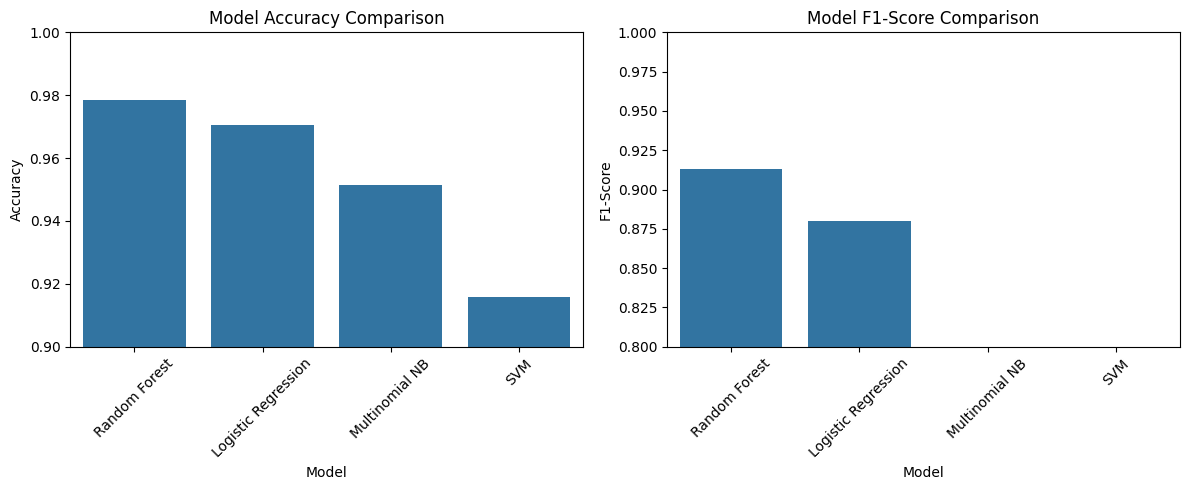

In [ ]:
# Visualize model performance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=performance_df, x='Model', y='Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0.9, 1.0)

plt.subplot(1, 2, 2)
sns.barplot(data=performance_df, x='Model', y='F1-Score')
plt.title('Model F1-Score Comparison')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)

plt.tight_layout()
plt.show()

### Step 15: Detailed Analysis of Best Model

In [ ]:
# Get the best model based on F1-score
best_model_name = performance_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"F1-Score: {results[best_model_name]['f1_score']:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, best_predictions,
                          target_names=['Ham', 'Spam']))

Best Model: Random Forest
Accuracy: 0.9785
F1-Score: 0.9130

Detailed Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.99      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



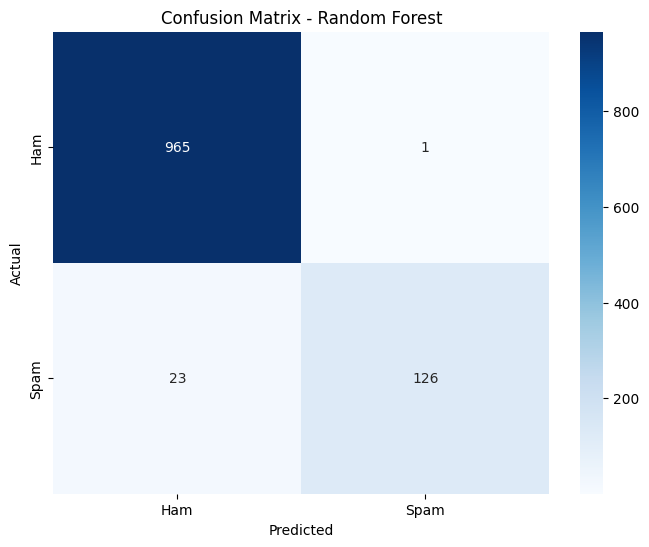

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Step 16: Feature Importance Analysis

In [ ]:
# Analyze feature importance (for interpretable models)
if hasattr(best_model, 'coef_'):
    # For linear models
    feature_names = list(tfidf_vectorizer.get_feature_names_out()) + list(additional_features_df.columns)
    importance = best_model.coef_[0]

    # Get top features for spam classification
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    print("Top 20 features for spam detection:")
    print(feature_importance.head(20))

    # Plot top features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(10)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title('Top 10 Features for Spam Detection')
    plt.tight_layout()
    plt.show()

### Step 17: Save the Model and Vectorizer

In [ ]:
import joblib

# Save the best model and vectorizer
model_filename = 'spam_classifier_model.pkl'
vectorizer_filename = 'tfidf_vectorizer.pkl'
additional_features_filename = 'additional_features_columns.pkl'

joblib.dump(best_model, model_filename)
joblib.dump(tfidf_vectorizer, vectorizer_filename)
joblib.dump(additional_features_df.columns.tolist(), additional_features_filename)

print("Model and preprocessing objects saved successfully!")
print(f"Model: {model_filename}")
print(f"Vectorizer: {vectorizer_filename}")
print(f"Feature columns: {additional_features_filename}")

Model and preprocessing objects saved successfully!
Model: spam_classifier_model.pkl
Vectorizer: tfidf_vectorizer.pkl
Feature columns: additional_features_columns.pkl


### Test

In [44]:
# Simple Colab-based interface
import ipywidgets as widgets
from IPython.display import display, HTML
import joblib

# Load models
model = joblib.load('spam_classifier_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
feature_columns = joblib.load('additional_features_columns.pkl')

# Create widgets
message_input = widgets.Textarea(
    value='',
    placeholder='Enter your SMS message here...',
    description='Message:',
    layout=widgets.Layout(width='80%', height='100px')
)

analyze_button = widgets.Button(
    description='🔍 Analyze Message',
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

output = widgets.Output()

def analyze_message(b):
    with output:
        output.clear_output()
        message = message_input.value.strip()

        if not message:
            print("⚠️ Please enter a message to analyze.")
            return

        # Preprocess and predict
        cleaned_message = preprocess_text(message, stem=True)
        tfidf_features = tfidf_vectorizer.transform([cleaned_message])
        additional_features = extract_additional_features(message)
        additional_features_df = pd.DataFrame([additional_features])[feature_columns].astype(float)

        from scipy.sparse import hstack
        features_combined = hstack([tfidf_features, additional_features_df])

        prediction = model.predict(features_combined)[0]
        probability = model.predict_proba(features_combined)[0]

        # Display results
        print("📊 ANALYSIS RESULTS")
        print("=" * 50)

        if prediction == 1:
            print("🚨 SPAM DETECTED!")
        else:
            print("✅ LEGITIMATE MESSAGE (HAM)")

        print(f"\nProbability Scores:")
        print(f"  Ham: {probability[0]:.2%}")
        print(f"  Spam: {probability[1]:.2%}")

        print(f"\n📝 Message Features:")
        print(f"  Length: {len(message)} characters")
        print(f"  Words: {len(message.split())}")
        print(f"  Uppercase ratio: {additional_features['uppercase_ratio']:.2%}")
        print(f"  Exclamation marks: {additional_features['exclamation_count']}")
        print(f"  Contains 'free': {'Yes' if additional_features['has_free'] else 'No'}")
        print(f"  Contains URL: {'Yes' if additional_features['has_url'] else 'No'}")

analyze_button.on_click(analyze_message)

# Display the interface
print("📱 SMS Spam Classifier - Colab Interface")
print("Enter a message below and click 'Analyze Message'")
display(message_input)
display(analyze_button)
display(output)

📱 SMS Spam Classifier - Colab Interface
Enter a message below and click 'Analyze Message'


Textarea(value='', description='Message:', layout=Layout(height='100px', width='80%'), placeholder='Enter your…

Button(button_style='primary', description='🔍 Analyze Message', layout=Layout(width='200px'), style=ButtonStyl…

Output()